In [275]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
import chardet
import math


from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import root_mean_squared_error
from math import sqrt

from sklearn.linear_model import Ridge, Lasso
from sklearn.model_selection import GridSearchCV

from sklearn.ensemble import RandomForestRegressor
import xgboost
import sklearn
from xgboost import XGBRegressor

import os
import zipfile


# Seoul Bike Sharing Demand Dataset:

#### https://archive.ics.uci.edu/dataset/560/seoul+bike+sharing+demand


### Data Loading and Overview:

In [276]:
# Download latest version
zip_path = r'seoul+bike+sharing+demand.zip'
extract_dir = r'D:\MLZoomcamp\Capstone_2_project'  

In [277]:
# Open the ZIP file in 'read' mode and extract all contents
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)


In [278]:
with open('SeoulBikeData.csv', 'rb') as f:
    rawdata = f.read(100000)  # read a portion or entire file
    result = chardet.detect(rawdata)
    print(result)

{'encoding': 'ISO-8859-9', 'confidence': 0.7583842623371586, 'language': 'Turkish'}


In [279]:
df = pd.read_csv('SeoulBikeData.csv', encoding='ISO-8859-9')
df.head()

,Date,Rented Bike Count,Hour,Temperature(°C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(°C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Seasons,Holiday,Functioning Day
0,01/12/2017,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
1,01/12/2017,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
2,01/12/2017,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,Winter,No Holiday,Yes
3,01/12/2017,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
4,01/12/2017,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,Winter,No Holiday,Yes


In [280]:
pd.set_option('display.max_columns', None)

### Check for duplicates:

In [281]:
def duplicate_values(df):

    num_duplicates = df.duplicated(subset=None, keep='first').sum()
    if num_duplicates > 0:
        print("There are", num_duplicates, "duplicated observations in the dataset.")
        df.drop_duplicates(keep='first', inplace=True)
        print(num_duplicates, "duplicates were dropped!")
        print("No more duplicate rows!")
    else:
        print("There are no duplicated observations in the dataset.")
        
duplicate_values(df)

There are no duplicated observations in the dataset.


In [282]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 14 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Date                       8760 non-null   object 
 1   Rented Bike Count          8760 non-null   int64  
 2   Hour                       8760 non-null   int64  
 3   Temperature(°C)            8760 non-null   float64
 4   Humidity(%)                8760 non-null   int64  
 5   Wind speed (m/s)           8760 non-null   float64
 6   Visibility (10m)           8760 non-null   int64  
 7   Dew point temperature(°C)  8760 non-null   float64
 8   Solar Radiation (MJ/m2)    8760 non-null   float64
 9   Rainfall(mm)               8760 non-null   float64
 10  Snowfall (cm)              8760 non-null   float64
 11  Seasons                    8760 non-null   object 
 12  Holiday                    8760 non-null   object 
 13  Functioning Day            8760 non-null   objec

In [283]:
#let's change date type for date:
df["Date"] = pd.to_datetime(df["Date"], dayfirst=True)
df['datetime'] = df['Date'] + pd.to_timedelta(df['Hour'], unit='h')

In [284]:
# Set 'datetime' as the index and sort
df.set_index('datetime', inplace=True)
df.sort_index(inplace=True)

In [285]:
#Lets split date between day/month/year:
df['Day']=df['Date'].dt.day
df['Month']=df['Date'].dt.month
df['Year']=df['Date'].dt.year

In [286]:
df.head()

,Date,Rented Bike Count,Hour,Temperature(°C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(°C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Seasons,Holiday,Functioning Day,Day,Month,Year
datetime,,,,,,,,,,,,,,,,,
2017-12-01 00:00:00,2017-12-01,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes,1,12,2017
2017-12-01 01:00:00,2017-12-01,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes,1,12,2017
2017-12-01 02:00:00,2017-12-01,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,Winter,No Holiday,Yes,1,12,2017
2017-12-01 03:00:00,2017-12-01,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes,1,12,2017
2017-12-01 04:00:00,2017-12-01,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,Winter,No Holiday,Yes,1,12,2017


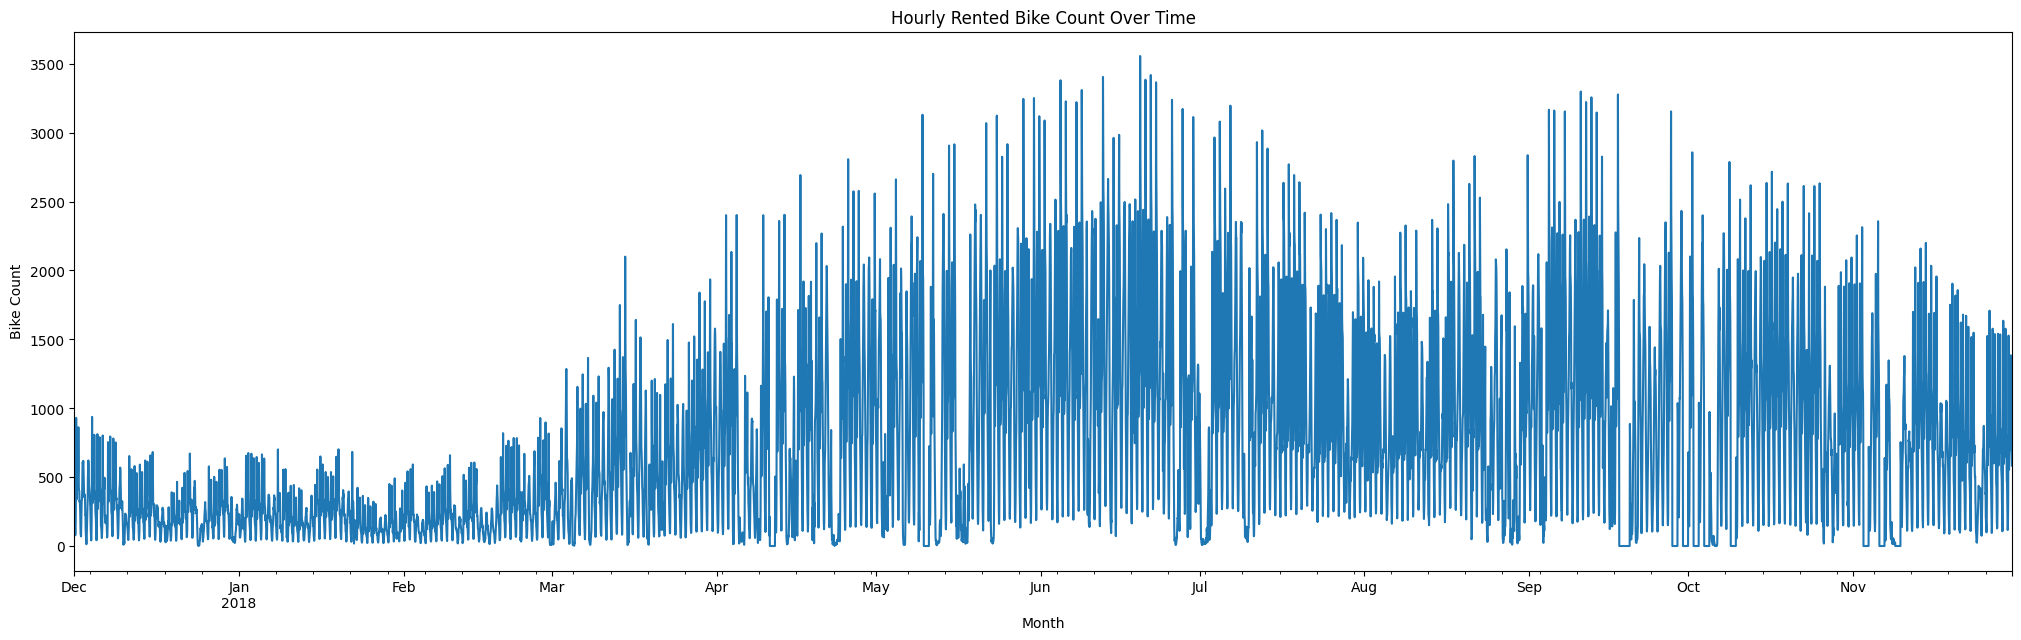

In [287]:
#Let's visualise 
plt.figure(figsize=(25, 7))
df['Rented Bike Count'].plot()
plt.title("Hourly Rented Bike Count Over Time")
plt.xlabel("Month")
plt.ylabel("Bike Count")
plt.show()

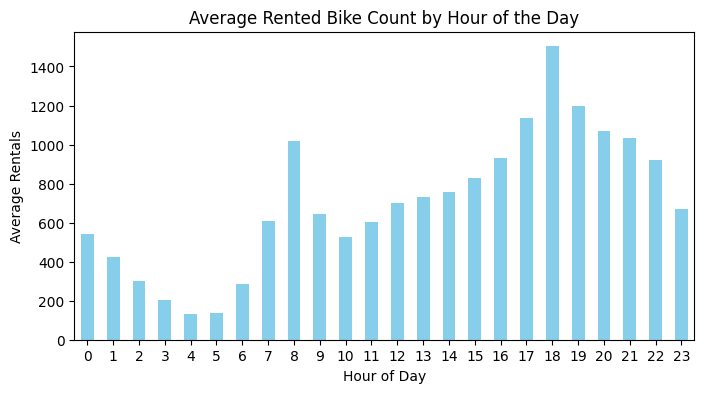

In [288]:
# Extract the hour from the datetime index (if not already in a separate column)
df['hour'] = df.index.hour 

hourly_avg = df.groupby('hour')['Rented Bike Count'].mean()

plt.figure(figsize=(8, 4))
hourly_avg.plot(kind='bar', color='skyblue')
plt.title("Average Rented Bike Count by Hour of the Day")
plt.xlabel("Hour of Day")
plt.ylabel("Average Rentals")
plt.xticks(rotation=0)
plt.show()

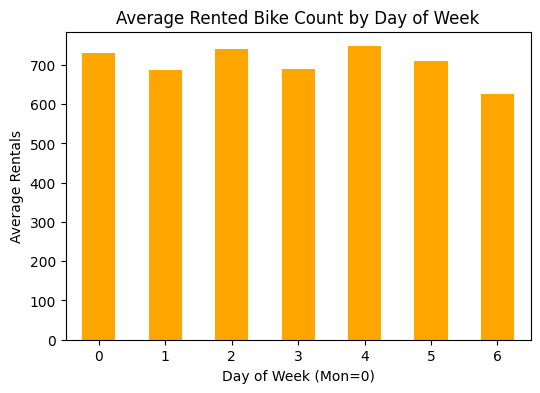

In [289]:
df['day_of_week'] = df.index.dayofweek  # Monday=0, Sunday=6
dow_avg = df.groupby('day_of_week')['Rented Bike Count'].mean()

plt.figure(figsize=(6, 4))
dow_avg.plot(kind='bar', color='orange')
plt.title("Average Rented Bike Count by Day of Week")
plt.xlabel("Day of Week (Mon=0)")
plt.ylabel("Average Rentals")
plt.xticks(rotation=0)
plt.show()

In [290]:
#Let's make all columns lowercased and change space on underscore:

df = df.rename(columns=lambda x: x.strip().lower().replace(' ', '_'))
print(df.columns)

Index(['date', 'rented_bike_count', 'hour', 'temperature(°c)', 'humidity(%)',
       'wind_speed_(m/s)', 'visibility_(10m)', 'dew_point_temperature(°c)',
       'solar_radiation_(mj/m2)', 'rainfall(mm)', 'snowfall_(cm)', 'seasons',
       'holiday', 'functioning_day', 'day', 'month', 'year', 'hour',
       'day_of_week'],
      dtype='object')


In [291]:
df.columns = (
    df.columns.str.lower()
    .str.strip()
    .str.replace('[()/%]', '', regex=True)  # remove parentheses, slash, percent
    .str.replace(' ', '_')
    .str.replace('°c', '_c')
    .str.replace('mj/m2', 'mj_m2')
)

In [292]:
#somehow we have 2 columns hour, let's rename one and drop:
df.columns.values[2]  = 'hour'  # the first hour
df.columns.values[18] = 'hour_extracted'  # the second hour

In [293]:
df.drop('hour_extracted', axis=1, inplace=True)

In [294]:
#Let's check categorical columns:
categorical_cols = df.select_dtypes(include=['object', 'category']).columns

In [295]:
# Now let's see what unique values each categorical column contains
for col in categorical_cols:
    print(f"Column: {col}")
    print("Unique values:", df[col].unique())
    print("Value counts:\n", df[col].value_counts(), "\n")

Column: seasons
Unique values: ['Winter' 'Spring' 'Summer' 'Autumn']
Value counts:
 seasons
Spring    2208
Summer    2208
Autumn    2184
Winter    2160
Name: count, dtype: int64 

Column: holiday
Unique values: ['No Holiday' 'Holiday']
Value counts:
 holiday
No Holiday    8328
Holiday        432
Name: count, dtype: int64 

Column: functioning_day
Unique values: ['Yes' 'No']
Value counts:
 functioning_day
Yes    8465
No      295
Name: count, dtype: int64 



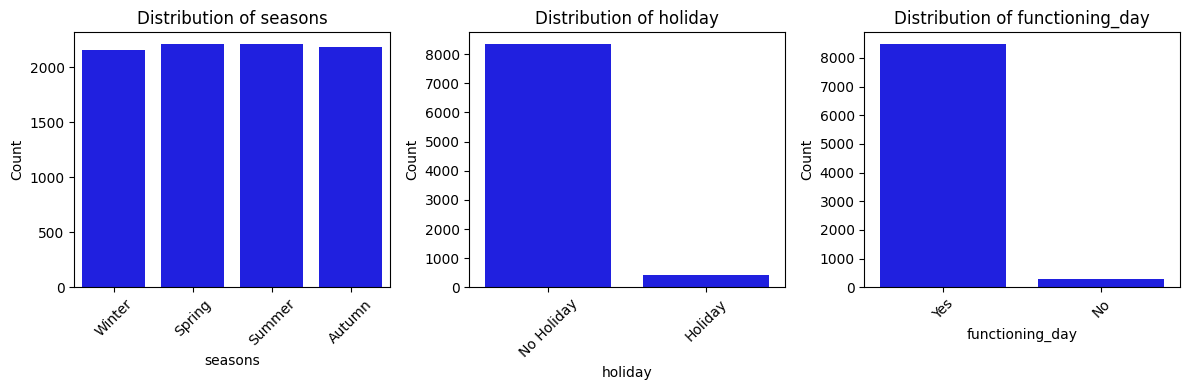

In [296]:
#visualisation of categorical features:

features = categorical_cols
n_cols = 3
n_rows = -(-len(features) // n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 4 * n_rows))
axes = axes.flatten()

for i, feature in enumerate(features):
    sns.countplot(x=feature, data=df, ax=axes[i], color='blue')
    axes[i].set_title(f'Distribution of {feature}')
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('Count')
    axes[i].tick_params(axis='x', rotation=45)

# Remove any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [297]:
#Let's check numerical columns:
num_cols = df.select_dtypes(include=['int64', 'float64']).columns

In [298]:
num_cols

Index(['rented_bike_count', 'hour', 'temperature_c', 'humidity',
       'wind_speed_ms', 'visibility_10m', 'dew_point_temperature_c',
       'solar_radiation_mjm2', 'rainfallmm', 'snowfall_cm'],
      dtype='object')

In [299]:
print("Descriptive Statistics for Numerical Columns:")
display(df[num_cols].describe().T)

Descriptive Statistics for Numerical Columns:


,count,mean,std,min,25%,50%,75%,max
rented_bike_count,8760.0,704.602055,644.997468,0.0,191.00,504.50,1065.25,3556.00
hour,8760.0,11.500000,6.922582,0.0,5.75,11.50,17.25,23.00
hour,8760.0,11.500000,6.922582,0.0,5.75,11.50,17.25,23.00
temperature_c,8760.0,12.882922,11.944825,-17.8,3.50,13.70,22.50,39.40
humidity,8760.0,58.226256,20.362413,0.0,42.00,57.00,74.00,98.00
wind_speed_ms,8760.0,1.724909,1.036300,0.0,0.90,1.50,2.30,7.40
visibility_10m,8760.0,1436.825799,608.298712,27.0,940.00,1698.00,2000.00,2000.00
dew_point_temperature_c,8760.0,4.073813,13.060369,-30.6,-4.70,5.10,14.80,27.20
solar_radiation_mjm2,8760.0,0.569111,0.868746,0.0,0.00,0.01,0.93,3.52
rainfallmm,8760.0,0.148687,1.128193,0.0,0.00,0.00,0.00,35.00


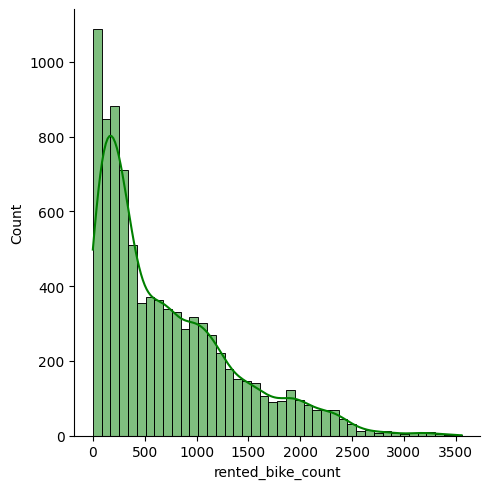

In [300]:
sns.displot(df['rented_bike_count'],kde=True,color='g')

<Figure size 800x600 with 0 Axes>

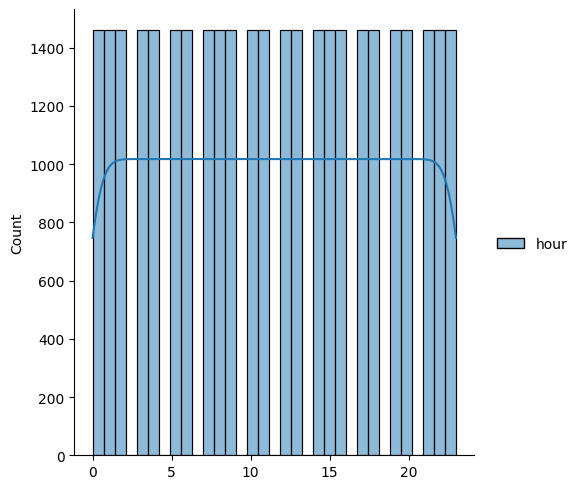

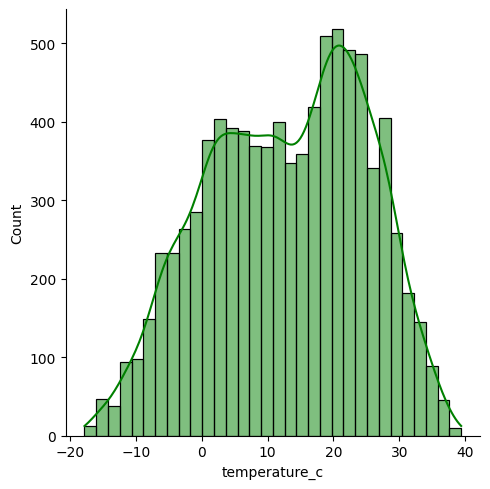

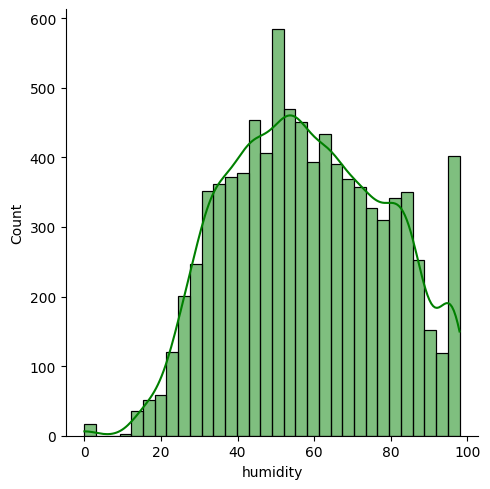

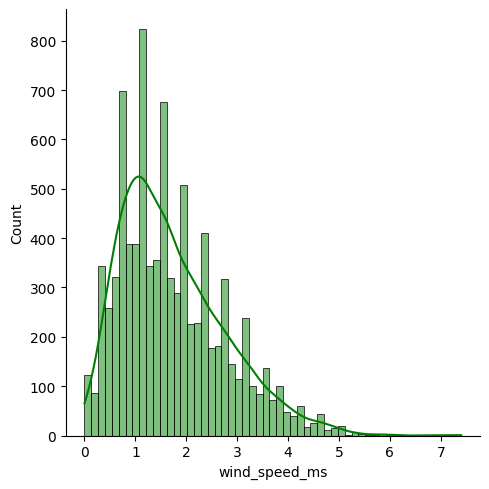

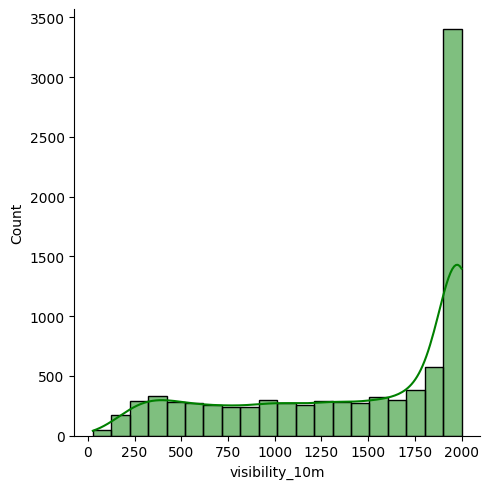

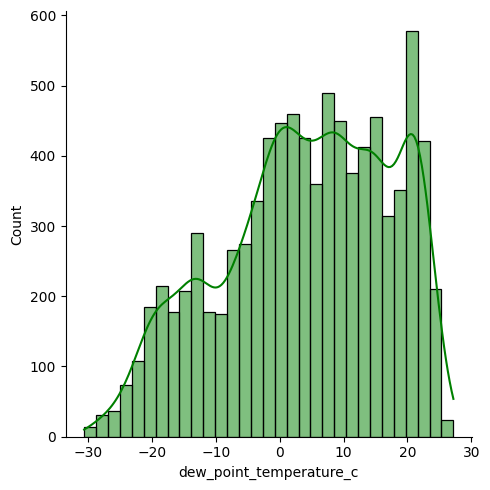

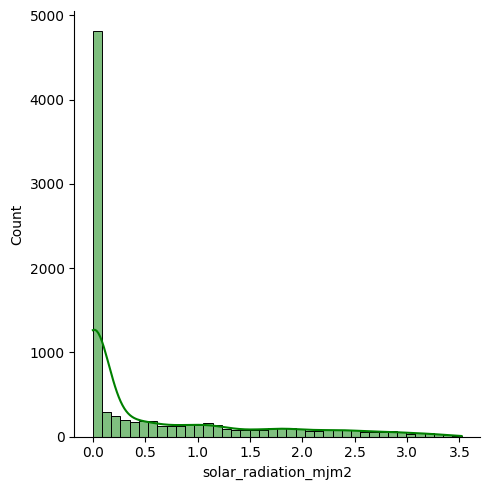

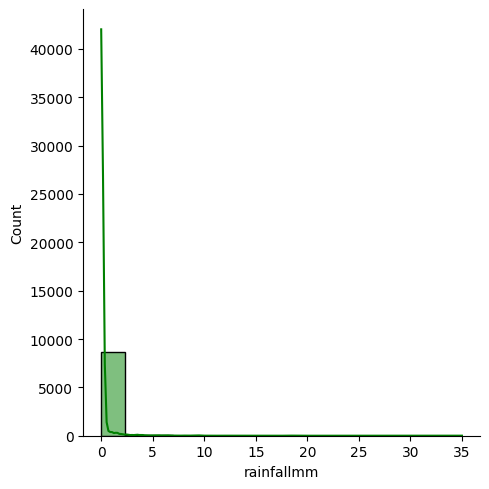

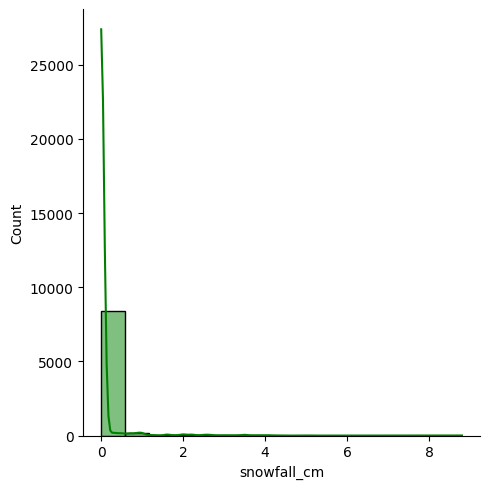

In [301]:
plt.figure(figsize=(8,6))
numeric=['hour', 'temperature_c', 'humidity',
       'wind_speed_ms', 'visibility_10m', 'dew_point_temperature_c',
       'solar_radiation_mjm2', 'rainfallmm', 'snowfall_cm']
for i in numeric:
  sns.displot(df[i],kde=True,color='g')

### Correlation Matrix:

In [302]:
#Let's encode ctegorical columns in order to include them in correlation matrix:
df_encoded = df.copy()

# Convert categorical columns to one-hot
df_encoded = pd.get_dummies(df_encoded, 
                            columns=['seasons', 'holiday', 'functioning_day'], 
                            drop_first=False)


corr_matrix = df_encoded.corr()
corr_with_target = corr_matrix['rented_bike_count'].sort_values(ascending=False)
print(corr_with_target)


rented_bike_count          1.000000
temperature_c              0.538558
hour                       0.410257
hour                       0.410257
dew_point_temperature_c    0.379788
date                       0.340772
seasons_Summer             0.296549
solar_radiation_mjm2       0.261837
year                       0.215162
functioning_day_Yes        0.203943
visibility_10m             0.199280
month                      0.133514
wind_speed_ms              0.121108
seasons_Autumn             0.102753
holiday_No Holiday         0.072338
seasons_Spring             0.022888
day                        0.022291
holiday_Holiday           -0.072338
rainfallmm                -0.123074
snowfall_cm               -0.141804
humidity                  -0.199780
functioning_day_No        -0.203943
seasons_Winter            -0.424925
Name: rented_bike_count, dtype: float64


In [303]:
df_encoded.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8760 entries, 2017-12-01 00:00:00 to 2018-11-30 23:00:00
Data columns (total 23 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   date                     8760 non-null   datetime64[ns]
 1   rented_bike_count        8760 non-null   int64         
 2   hour                     8760 non-null   int64         
 3   temperature_c            8760 non-null   float64       
 4   humidity                 8760 non-null   int64         
 5   wind_speed_ms            8760 non-null   float64       
 6   visibility_10m           8760 non-null   int64         
 7   dew_point_temperature_c  8760 non-null   float64       
 8   solar_radiation_mjm2     8760 non-null   float64       
 9   rainfallmm               8760 non-null   float64       
 10  snowfall_cm              8760 non-null   float64       
 11  day                      8760 non-null   int32         
 12

In [304]:
df_encoded.drop('date', axis =1,  inplace = True)

In [305]:
df_encoded.columns[df_encoded.columns.duplicated()]

Index(['hour'], dtype='object')

In [306]:
df = df_encoded.drop(df_encoded.columns[1], axis=1)

In [307]:
df.columns[df.columns.duplicated()]

Index([], dtype='object')

### Train/Test/Validation split:

In [308]:
#  #Split the data into 3 parts: train/validation/test with 60%/20%/20% distribution
df_train_full, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_train_full, test_size=0.25, random_state=1)
     

In [309]:
# ## Reset the Dataframe indexes
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [310]:
# # Define features and target variable
X_train = df_train.drop('rented_bike_count', axis=1)
X_val = df_val.drop('rented_bike_count', axis=1)
X_test = df_test.drop('rented_bike_count', axis=1)
     

In [311]:
# Setup the target arrays
y_train = df_train['rented_bike_count'].values
y_val = df_val['rented_bike_count'].values
y_test = df_test['rented_bike_count'].values

In [312]:
len(df_train), len(df_val), len(df_test)

(5256, 1752, 1752)

# # Models training and tuning:

### Linear regression:

In [313]:
# Create an empty DataFrame to store results
results = pd.DataFrame(columns=['Model', 'Validation RMSE', 'Test RMSE', 'R² Score'])

In [314]:
# # Initialize the model
lr = LinearRegression()

# Fit the model on the training data
lr.fit(X_train, y_train)

# Predict on the validation set
y_pred_val_lr = lr.predict(X_val)
rmse_val_lr = root_mean_squared_error(y_val, y_pred_val_lr)

In [315]:
# Test predictions and RMSE
y_pred_test_lr = lr.predict(X_test)
rmse_test_lr = root_mean_squared_error(y_test, y_pred_test_lr)

# R² Score
r2_test_lr = lr.score(X_test, y_test)

# Append results to the table
lr_results = pd.DataFrame([{
    'Model': 'Linear Regression',
    'Validation RMSE': rmse_val_lr,
    'Test RMSE': rmse_test_lr,
    'R² Score': r2_test_lr
}])

# Concatenate with the results DataFrame
results = pd.concat([results, lr_results], ignore_index=True)

print(f"Validation RMSE: {rmse_val_lr:.5f}")
print(f"Test RMSE: {rmse_test_lr:.5f}")
print(f"Test R^2: {r2_test_lr:.5}")


Validation RMSE: 461.80959
Test RMSE: 465.52590
Test R^2: 0.47564


C:\Users\Yuliya Lavrenyuk\AppData\Local\Temp\ipykernel_22124\3499615329.py:17: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, lr_results], ignore_index=True)


###  Regularized Linear Regression: Ridge and Lasso:

In [319]:
# Ridge Regression

alpha_values = [0.1, 1, 10, 100]

In [320]:
best_alpha = None
best_rmse = float('inf')  # Set initial best RMSE to infinity
best_model = None

In [321]:
for alpha in alpha_values:
    # Initialize and fit the Ridge model
    ridge = Ridge(alpha=alpha)
    ridge.fit(X_train, y_train)
    # Predict on the validation set
    y_pred_val = ridge.predict(X_val)
    
    # Calculate RMSE for the validation set
    rmse_val_ridge = root_mean_squared_error(y_val, y_pred_val)
    
    print(f"Alpha: {alpha}, Validation RMSE: {rmse_val_ridge}")
    
    # Update the best parameters if the current RMSE is lower
    if rmse_val_ridge < best_rmse:
        best_alpha = alpha
        best_rmse = rmse_val_ridge
        best_model = ridge


print(f"Best Alpha: {best_alpha}, Best Validation RMSE: {best_rmse}")

Alpha: 0.1, Validation RMSE: 461.81652368519786
Alpha: 1, Validation RMSE: 461.88185755557913
Alpha: 10, Validation RMSE: 462.60125747116984
Alpha: 100, Validation RMSE: 467.60224740764374
Best Alpha: 0.1, Best Validation RMSE: 461.81652368519786


In [324]:
ridge_best = Ridge(0.1)  
ridge_best.fit(X_train, y_train)

Ridge(alpha=0.1)

In [325]:
# Calculate Validation Metrics
y_pred_val_ridge = ridge_best.predict(X_val)
rmse_val_ridge = root_mean_squared_error(y_val, y_pred_val_ridge)

In [326]:
y_pred_test_ridge = ridge_best.predict(X_test)
rmse_test_ridge = root_mean_squared_error(y_test, y_pred_test_ridge)  
r2_test_ridge = r2_score(y_test, y_pred_test_ridge) 

In [327]:
# Append results to the table
ridge_results = pd.DataFrame([{
    'Model': 'Ridge Regression',
    'Validation RMSE': rmse_val_ridge,  
    'Test RMSE': rmse_test_ridge,       
    'R² Score': r2_test_ridge           
}])

# Concatenate Ridge results with the results DataFrame
results = pd.concat([results, ridge_results], ignore_index=True)

# Display the updated results table
print(results)

               Model  Validation RMSE   Test RMSE  R² Score
0  Linear Regression       461.809589  465.525899  0.475637
1   Ridge Regression       461.816524  465.526143  0.475636


### lasso regression:

In [331]:
alpha_values = [0.01, 0.1, 1, 10, 50]

In [332]:
best_alpha_lasso = None
best_rmse_val_lasso = float('inf') 
best_lasso_model = None

In [334]:
for alpha in alpha_values:
    # Initialize and fit the Lasso model
    lasso = Lasso(alpha=alpha, max_iter=10000)
    lasso.fit(X_train, y_train)
    
    # Predict on the validation set
    y_pred_val_lasso = lasso.predict(X_val)
    
    # Calculate RMSE on the validation set
    rmse_val_lasso = root_mean_squared_error(y_val, y_pred_val_lasso)
    
    print(f"Alpha: {alpha}, Validation RMSE: {rmse_val_lasso}")
    
    # Update the best alpha and model if the current RMSE is lower
    if rmse_val_lasso < best_rmse_val_lasso:
        best_alpha_lasso = alpha
        best_rmse_val_lasso = rmse_val_lasso
        best_lasso_model = lasso

# Print the best alpha and validation RMSE
print(f"Best Alpha (Lasso): {best_alpha_lasso}")
print(f"Best Validation RMSE (Lasso): {best_rmse_val_lasso}")

Alpha: 0.01, Validation RMSE: 461.8179653394801
Alpha: 0.1, Validation RMSE: 461.9339975462061
Alpha: 1, Validation RMSE: 463.3399693260314
Alpha: 10, Validation RMSE: 477.2701513871845
Alpha: 50, Validation RMSE: 517.3780077362785
Best Alpha (Lasso): 0.01
Best Validation RMSE (Lasso): 461.8179653394801


In [335]:
# Predict on the test set
y_pred_test_lasso = best_lasso_model.predict(X_test)

# Calculate RMSE for the test set
rmse_test_lasso = root_mean_squared_error(y_test, y_pred_test_lasso)

# Calculate R² score for the test set
r2_test_lasso = r2_score(y_test, y_pred_test_lasso)

# Print the results
print(f"Lasso Test RMSE: {rmse_test_lasso}")
print(f"Lasso R² Score: {r2_test_lasso}")

Lasso Test RMSE: 465.5252341692752
Lasso R² Score: 0.47563832023109087


In [336]:
lasso_results = pd.DataFrame([{
    'Model': 'Lasso Regression',
    'Validation RMSE': best_rmse_val_lasso,
    'Test RMSE': rmse_test_lasso,
    'R² Score': r2_test_lasso
}])

# Concatenate Lasso results with the results DataFrame
results = pd.concat([results, lasso_results], ignore_index=True)

# Display the updated results table
print(results)

               Model  Validation RMSE   Test RMSE  R² Score
0  Linear Regression       461.809589  465.525899  0.475637
1   Ridge Regression       461.816524  465.526143  0.475636
2   Lasso Regression       461.817965  465.525234  0.475638


### Random forest regressor:

In [337]:
rf_param_grid = {
    'n_estimators': [50, 100, 200,500],
    'max_depth': [5, 10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

In [338]:
# Variables to store the best results
best_params_rf = None
best_rmse_val_rf = float('inf')
best_rf_model = None

In [340]:
# Manual search over the parameter grid
for n_estimators in rf_param_grid['n_estimators']:
    for max_depth in rf_param_grid['max_depth']:
        for min_samples_split in rf_param_grid['min_samples_split']:
            for min_samples_leaf in rf_param_grid['min_samples_leaf']:
                # Initialize the model with current parameters
                rf = RandomForestRegressor(
                    n_estimators=n_estimators,
                    max_depth=max_depth,
                    min_samples_split=min_samples_split,
                    min_samples_leaf=min_samples_leaf,
                    random_state=42,
                    n_jobs=-1
                )
                
                # Train the model
                rf.fit(X_train, y_train)
                
                # Predict on the validation set
                y_pred_val_rf = rf.predict(X_val)
                
                # Calculate RMSE
                rmse_val_rf = root_mean_squared_error(y_val, y_pred_val_rf)
                
                # Print current parameter combination and RMSE
                print(f"Params: n_estimators={n_estimators}, max_depth={max_depth}, "
                      f"min_samples_split={min_samples_split}, min_samples_leaf={min_samples_leaf} "
                      f"=> Validation RMSE: {rmse_val_rf}")
                
                # Update the best parameters if current RMSE is lower
                if rmse_val_rf < best_rmse_val_rf:
                    best_params_rf = {
                        'n_estimators': n_estimators,
                        'max_depth': max_depth,
                        'min_samples_split': min_samples_split,
                        'min_samples_leaf': min_samples_leaf
                    }
                    best_rmse_val_rf = rmse_val_rf
                    best_rf_model = rf

Params: n_estimators=50, max_depth=5, min_samples_split=2, min_samples_leaf=1 => Validation RMSE: 413.9105284551083
Params: n_estimators=50, max_depth=5, min_samples_split=2, min_samples_leaf=2 => Validation RMSE: 413.9283775000489
Params: n_estimators=50, max_depth=5, min_samples_split=2, min_samples_leaf=4 => Validation RMSE: 414.0540869393396
Params: n_estimators=50, max_depth=5, min_samples_split=5, min_samples_leaf=1 => Validation RMSE: 413.90700627907506
Params: n_estimators=50, max_depth=5, min_samples_split=5, min_samples_leaf=2 => Validation RMSE: 413.9286291277546
Params: n_estimators=50, max_depth=5, min_samples_split=5, min_samples_leaf=4 => Validation RMSE: 414.0540869393396
Params: n_estimators=50, max_depth=5, min_samples_split=10, min_samples_leaf=1 => Validation RMSE: 413.91631544917624
Params: n_estimators=50, max_depth=5, min_samples_split=10, min_samples_leaf=2 => Validation RMSE: 413.9523108938116
Params: n_estimators=50, max_depth=5, min_samples_split=10, min_samp

In [341]:
print(f"Best Parameters (Random Forest): {best_params_rf}")
print(f"Best Validation RMSE (Random Forest): {best_rmse_val_rf}")

Best Parameters (Random Forest): {'n_estimators': 200, 'max_depth': 20, 'min_samples_split': 2, 'min_samples_leaf': 1}
Best Validation RMSE (Random Forest): 330.8645554620515


In [342]:
y_pred_test_rf = best_rf_model.predict(X_test)

# Calculate RMSE for the test set
rmse_test_rf = root_mean_squared_error(y_test, y_pred_test_rf)

# Calculate R² score for the test set
r2_test_rf = r2_score(y_test, y_pred_test_rf)

In [343]:
rf_results = pd.DataFrame([{
    'Model': 'Random Forest',
    'Validation RMSE': rmse_val_rf,
    'Test RMSE': rmse_test_rf,
    'R² Score': r2_test_rf
}])

# Concatenate with the results DataFrame
results = pd.concat([results, rf_results], ignore_index=True)

In [344]:
# Display the updated results table
print(results)

               Model  Validation RMSE   Test RMSE  R² Score
0  Linear Regression       461.809589  465.525899  0.475637
1   Ridge Regression       461.816524  465.526143  0.475636
2   Lasso Regression       461.817965  465.525234  0.475638
3      Random Forest       340.735677  327.995615  0.739696


### XGBoost

In [351]:
# Define the parameter grid
xgb_param_grid = {
    'n_estimators': [50, 100, 200, 500, 1000, 2000],
    'learning_rate': [0.01,0.05,0.03, 0.1, 0.2,0.5],
    'max_depth': [3, 5, 7, 10],
    'silent': [1],
    'min_child_weight': [1, 3,4,5],
    'subsample': [0.7,0.8, 1.0],
    'colsample_bytree': [0.7,0.8, 1.0]
}

In [352]:
best_params_xgb = None
best_rmse_val_xgb = float('inf')
best_xgb_model = None

In [354]:
for n_estimators in xgb_param_grid['n_estimators']:
    for learning_rate in xgb_param_grid['learning_rate']:
        for max_depth in xgb_param_grid['max_depth']:
            for min_child_weight in xgb_param_grid['min_child_weight']:
                for subsample in xgb_param_grid['subsample']:
                    for colsample_bytree in xgb_param_grid['colsample_bytree']:
                        # Initialize the model with the current parameters
                        xgb = XGBRegressor(
                            n_estimators=n_estimators,
                            learning_rate=learning_rate,
                            max_depth=max_depth,
                            min_child_weight=min_child_weight,
                            subsample=subsample,
                            colsample_bytree=colsample_bytree,
                            random_state=42,
                            n_jobs=5,
                        )
                        
                        # Train the model
                        xgb.fit(X_train, y_train)
                        
                        # Predict on the validation set
                        y_pred_val_xgb = xgb.predict(X_val)
                        
                        # Calculate RMSE
                        rmse_val_xgb = root_mean_squared_error(y_val, y_pred_val_xgb)
                        
                        # Print current parameters and RMSE
                        print(f"Params: n_estimators={n_estimators}, learning_rate={learning_rate}, "
                              f"max_depth={max_depth}, min_child_weight={min_child_weight}, "
                              f"subsample={subsample}, colsample_bytree={colsample_bytree} "
                              f"=> Validation RMSE: {rmse_val_xgb}")
                        
                        # Update the best parameters if current RMSE is lower
                        if rmse_val_xgb < best_rmse_val_xgb:
                            best_params_xgb = {
                                'n_estimators': n_estimators,
                                'learning_rate': learning_rate,
                                'max_depth': max_depth,
                                'min_child_weight': min_child_weight,
                                'subsample': subsample,
                                'colsample_bytree': colsample_bytree
                            }
                            best_rmse_val_xgb = rmse_val_xgb
                            best_xgb_model = xgb

# Print the best parameters and validation RMSE
print(f"Best Parameters (XGBoost): {best_params_xgb}")
print(f"Best Validation RMSE (XGBoost): {best_rmse_val_xgb}")

Params: n_estimators=50, learning_rate=0.01, max_depth=3, min_child_weight=1, subsample=0.7, colsample_bytree=0.7 => Validation RMSE: 541.2340698242188
Params: n_estimators=50, learning_rate=0.01, max_depth=3, min_child_weight=1, subsample=0.7, colsample_bytree=0.8 => Validation RMSE: 538.9666137695312
Params: n_estimators=50, learning_rate=0.01, max_depth=3, min_child_weight=1, subsample=0.7, colsample_bytree=1.0 => Validation RMSE: 535.2551879882812
Params: n_estimators=50, learning_rate=0.01, max_depth=3, min_child_weight=1, subsample=0.8, colsample_bytree=0.7 => Validation RMSE: 541.3252563476562
Params: n_estimators=50, learning_rate=0.01, max_depth=3, min_child_weight=1, subsample=0.8, colsample_bytree=0.8 => Validation RMSE: 538.5616455078125
Params: n_estimators=50, learning_rate=0.01, max_depth=3, min_child_weight=1, subsample=0.8, colsample_bytree=1.0 => Validation RMSE: 535.2853393554688
Params: n_estimators=50, learning_rate=0.01, max_depth=3, min_child_weight=1, subsample=

In [355]:
#Predict on the test set
y_pred_test_xgb = best_xgb_model.predict(X_test)

# Calculate RMSE for the test set
rmse_test_xgb = root_mean_squared_error(y_test, y_pred_test_xgb)

# Calculate R² score for the test set
r2_test_xgb = best_xgb_model.score(X_test, y_test)

In [356]:
xgb_results = pd.DataFrame([{
    'Model': 'XGBoost Regressor',
    'Validation RMSE': best_rmse_val_xgb,
    'Test RMSE': rmse_test_xgb,
    'R² Score': r2_test_xgb
}])

# Concatenate XGBoost results with the results DataFrame
results = pd.concat([results, xgb_results], ignore_index=True)

# Display the updated results table
print(results)

               Model  Validation RMSE   Test RMSE  R² Score
0  Linear Regression       461.809589  465.525899  0.475637
1   Ridge Regression       461.816524  465.526143  0.475636
2   Lasso Regression       461.817965  465.525234  0.475638
3      Random Forest       340.735677  327.995615  0.739696
4  XGBoost Regressor       303.749084  304.518036  0.775627
5  XGBoost Regressor       301.023407  301.936371  0.779415


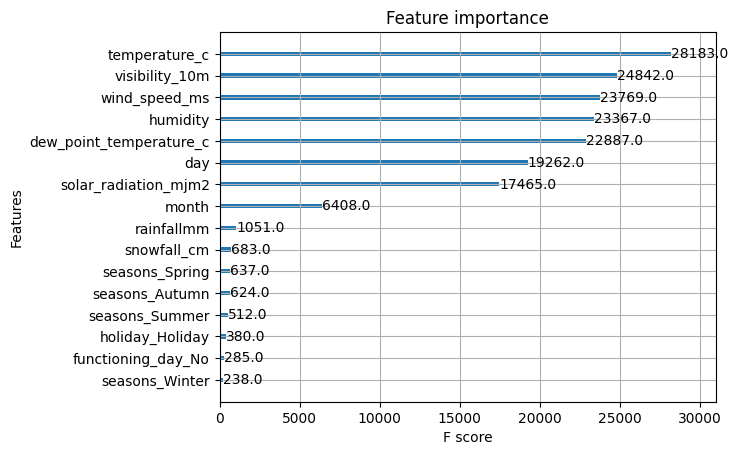

In [357]:
from xgboost import plot_importance

plot_importance(best_xgb_model, importance_type='weight')
plt.show()

In [358]:
import joblib

# Save the trained XGBoost model to a file
joblib.dump(best_xgb_model, 'xgboost_best_model.pkl')

print("Model saved as 'xgboost_best_model.pkl'")

Model saved as 'xgboost_best_model.pkl'


In [363]:
results.to_csv('model_results.csv', index=False)

print("Results saved to 'model_results.csv'")

Results saved to 'model_results.csv'
